# Real-Time Bitcoin Transaction Anomaly Detection

This notebook demonstrates an end-to-end implementation of a real-time anomaly detection system for Bitcoin transactions. The goal is to identify abnormal activity using blockchain data and generate human-readable explanations using Anthropic Claude.


## Objectives

- Extract real-time Bitcoin transaction data using Blockchair API
- Preprocess and aggregate data using PySpark
- Generate forensic explanations using Anthropic Claude
- Detect statistical anomalies using EWMA
- Detect coordinated attack patterns (fan-in/fan-out)
- Forecast future anomalies using Prophet
- Visualize key insights and launch an interactive dashboard

## Project Pipeline

### Data Pipeline
- Fetch real-time data from Blockchair API
- Clean and aggregate data using PySpark
- Handle imbalanced data via sampling + flagging

### Anomaly Detection
- Apply rule-based filters
- Generate natural-language risk reports using Claude

### Temporal Analysis
- Detect statistical deviations via EWMA
- Flag coordinated activity patterns
- Forecast future risk windows

### Operational Layer
- Alert via Slack
- Visualize in Dash dashboard

## Important Notes Before You Run

- Ensure `.env` file is in the root folder with your Claude and Slack keys.
- Make sure Java is installed and accessible via terminal (`java -version`).
- Docker users must expose the right ports and volumes to access Spark and Dash.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load API Keys

Load Claude and Slack credentials from the `.env` file located in the project root. This enables access to explanation and alerting services.

In [3]:
import os
from dotenv import load_dotenv
from pathlib import Path
from anthropic import Anthropic

env_path = os.path.abspath(os.path.join(os.getcwd(), '..', '.env'))
load_dotenv(dotenv_path=env_path)

CLAUDE_KEY = os.getenv("ANTHROPIC_API_KEY")
SLACK_WEBHOOK = os.getenv("SLACK_WEBHOOK_URL")

client = Anthropic(api_key=CLAUDE_KEY)

## Configure Java (Mac ARM Support)

Ensure Spark can find the correct JAVA_HOME, especially on ARM (Mac M1/M2/M3) systems.

In [4]:
import subprocess

java_home = subprocess.check_output(
    "dirname $(dirname $(readlink -f $(which java)))", shell=True, text=True
).strip()

os.environ["JAVA_HOME"] = java_home
os.environ["PATH"] = f"{java_home}/bin:" + os.environ["PATH"]

print("[JAVA CONFIGURED] JAVA_HOME set to:", java_home)

[JAVA CONFIGURED] JAVA_HOME set to: /usr/lib/jvm/java-11-openjdk-arm64


## Start Spark

We use Spark for large-scale JSON processing and 1-minute/5-minute aggregation.

In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BTC Preprocessing with Aggregation") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

## Extract Blockchain Data

We call the Blockchair API to retrieve ~4000 recent Bitcoin transactions. Each batch is saved as a `.json` file in `data/raw/`.

In [7]:
import sys
sys.path.append("../scripts")
from BitcoinTxAnomaly_utils import run_extract

run_extract()

[RUN] Running extract_and_upload.py...
[INFO] Starting extraction for today (latest transactions)...
[INFO] Fetching offset 0...
[INFO] Saved: batch_20250517_181352_page0.json
[INFO] Fetching offset 100...
[INFO] Saved: batch_20250517_181355_page1.json
[INFO] Fetching offset 200...
[INFO] Saved: batch_20250517_181358_page2.json
[INFO] Fetching offset 300...
[INFO] Saved: batch_20250517_181401_page3.json
[INFO] Fetching offset 400...
[INFO] Saved: batch_20250517_181404_page4.json
[INFO] Fetching offset 500...
[INFO] Saved: batch_20250517_181407_page5.json
[INFO] Fetching offset 600...
[INFO] Saved: batch_20250517_181411_page6.json
[INFO] Fetching offset 700...
[INFO] Saved: batch_20250517_181414_page7.json
[INFO] Fetching offset 800...
[INFO] Saved: batch_20250517_181417_page8.json
[INFO] Fetching offset 900...
[INFO] Saved: batch_20250517_181421_page9.json
[INFO] Fetching offset 1000...
[INFO] Saved: batch_20250517_181424_page10.json
[INFO] Fetching offset 1100...
[INFO] Saved: batch_2

## Preprocess with Spark

This step:
- Cleans and parses transaction fields
- Aggregates values in 1-minute and 5-minute buckets
- Produces a clean `cleaned_transactions.csv` and `tx_agg_1min.csv`

In [10]:
from BitcoinTxAnomaly_utils import run_preprocess

run_preprocess()

[RUN] Running preprocess_with_spark.py...
:: loading settings :: url = jar:file:/usr/local/lib/python3.8/dist-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-24e8ff90-02e6-443d-bf2e-bda8d47e2ac1;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.1026 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 125ms :: artifacts dl 4ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.1026 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.2 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------

[INFO] Starting Spark preprocessing...


25/05/17 18:18:34 INFO SparkContext: Running Spark version 3.5.5
25/05/17 18:18:34 INFO SparkContext: OS info Linux, 6.10.14-linuxkit, aarch64
25/05/17 18:18:34 INFO SparkContext: Java version 11.0.27
25/05/17 18:18:34 INFO ResourceUtils: ==============================================================
25/05/17 18:18:34 INFO ResourceUtils: No custom resources configured for spark.driver.
25/05/17 18:18:34 INFO ResourceUtils: ==============================================================
25/05/17 18:18:34 INFO SparkContext: Submitted application: BitcoinTransactionPreprocessing
25/05/17 18:18:34 INFO ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 1024, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
25/05/17 18:18:34 INFO ResourceProfile: Limiting resource is cpu
25/05/17 18:18:34 INFO ResourcePro

[INFO] Spark preprocessing completed. Files saved to data/processed/


## Anomaly Detection using Claude

We use Anthropic Claude to evaluate each 1-minute window and generate a structured explanation report. This replaces the need for opaque ML models and allows for auditability.

In [11]:
from BitcoinTxAnomaly_utils import run_explanation

run_explanation()

[RUN] Running anomaly_explainer.py...
[INFO] Explaining Bitcoin transactions with Claude...
[INFO] Explaining transaction 18...

--- Explanation for transaction 18 ---
Bitcoin On-Chain Activity Report

1. Statistical Abnormality Assessment
The provided transaction summary shows an average transaction value of 71,920,352 satoshis (0.719 BTC) over a 1-minute window. This is significantly higher than Bitcoin's historical average transaction value of ~2 BTC. The average fee of 1,223 satoshis is not unusually high. The fee-to-value ratio of 0.04% is lower than typical, suggesting high-value transactions are not paying a premium fee rate. Input and output counts are slightly elevated but not extreme outliers. Overall transaction size is modestly higher than average.

In summary, the standout abnormal metric is the high average transaction value concentrated in a short time window. This warrants further pattern analysis.

2. Potential Suspicious Patterns  
The high-value transactions with low

/workspace/scripts/anomaly_explainer.py:63: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  existing["window_start"] = pd.to_datetime(existing["window_start"], errors='coerce')


## EWMA Anomaly Detection

We now track transaction count anomalies using exponentially weighted moving averages. This allows us to flag time windows where activity spikes beyond expected norms.

### Slack Alert Explanation (EWMA Anomalies)

Each detected anomaly is sent to Slack using a structured alert format for better readability. The alert includes:

- **Time**: The 1-minute window when the anomaly was detected.
- **Tx Count**: Total number of Bitcoin transactions in that window.
- **Z-Score**: Statistical deviation from the EWMA-smoothed baseline. Values with `|z| > 2` are flagged.
- **Context**: A note explaining that the anomaly was detected due to statistical deviation.

This helps teams monitor blockchain anomalies in real time without manually reviewing CSVs or dashboards.

In [13]:
from BitcoinTxAnomaly_utils import run_anomaly_detection

run_anomaly_detection()

[RUN] Running track_anomalies.py...
[INFO] Running EWMA anomaly detection...
[SUCCESS] EWMA tracking completed. Saved to: ../report/ewma_anomalies.csv
[INFO] Alert sent to Slack.


## Detect Coordinated Attacks

We check for high-input or high-output transactions in the same minute, which may indicate spammy “fan-in” or “fan-out” behavior often used in obfuscation.

### Coordinated Attack Slack Alert Format

When multiple transactions show fan-in (≥10 inputs) or fan-out (≥10 outputs) patterns within the same minute, an alert is triggered and sent to Slack.

The alert displays:

- **Time**: Minute-level timestamp of the detected cluster.
- **Tx Count**: Number of structurally flagged transactions in that minute.
- **Avg Inputs / Outputs**: Mean structural values for the group.
- **Sample Tx**: One of the representative transactions involved.

These alerts are formatted using Slack blocks for improved readability and are useful in detecting spam or laundering patterns in real time.

In [14]:
from BitcoinTxAnomaly_utils import run_coordinated_attack_check

run_coordinated_attack_check()

[RUN] Running detect_coordinated_attacks.py...
[INFO] Detecting coordinated attacks...
[INFO] Coordinated attack candidates saved to: ../report/coordinated_attacks.csv
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to Slack.
[INFO] Alert sent to

## Send Slack Alerts

Detected anomalies or attack candidates can be pushed as alerts to Slack in real time.

In [15]:
from BitcoinTxAnomaly_utils import run_alert

run_alert()

[RUN] Running send_alert.py...


## Visualize EWMA Anomalies

This plot shows transaction counts and EWMA curves, with anomalies highlighted.

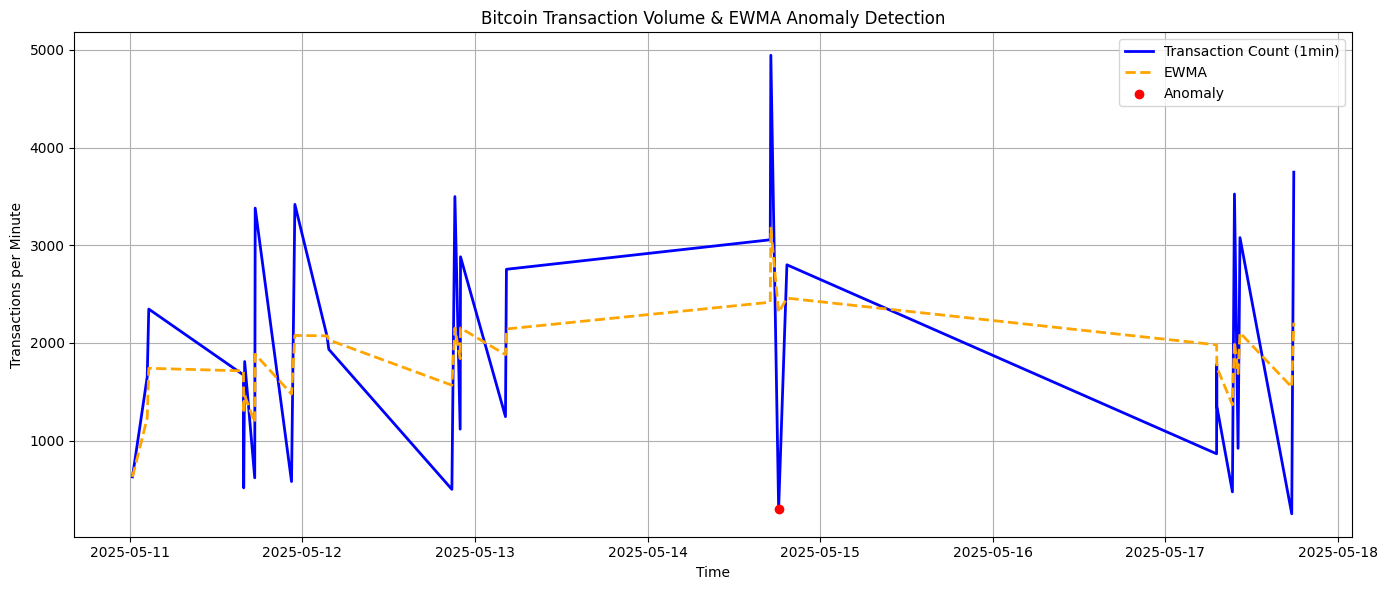

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the EWMA output
ewma_df = pd.read_csv("../report/ewma_anomalies.csv", parse_dates=["window_start"])

# Basic line plot with anomaly markers
plt.figure(figsize=(14, 6))
plt.plot(ewma_df["window_start"], ewma_df["tx_count_1min"], label="Transaction Count (1min)", color="blue", linewidth=2)
plt.plot(ewma_df["window_start"], ewma_df["ewma"], label="EWMA", color="orange", linestyle="--", linewidth=2)

# Highlight anomalies
anomalies = ewma_df[ewma_df["is_anomaly"] == 1]
plt.scatter(anomalies["window_start"], anomalies["tx_count_1min"], color="red", label="Anomaly", zorder=5)

# Plot settings
plt.title("Bitcoin Transaction Volume & EWMA Anomaly Detection")
plt.xlabel("Time")
plt.ylabel("Transactions per Minute")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Z-Score Heatmap by Hour and Date

This heatmap visualizes the average Z-score across different hours and days. Brighter red or blue regions indicate strong statistical deviations in transaction activity during those times.

It helps identify when anomalies are not just isolated spikes but part of repeating hourly patterns — e.g., time-of-day-based attacks or high activity bursts.

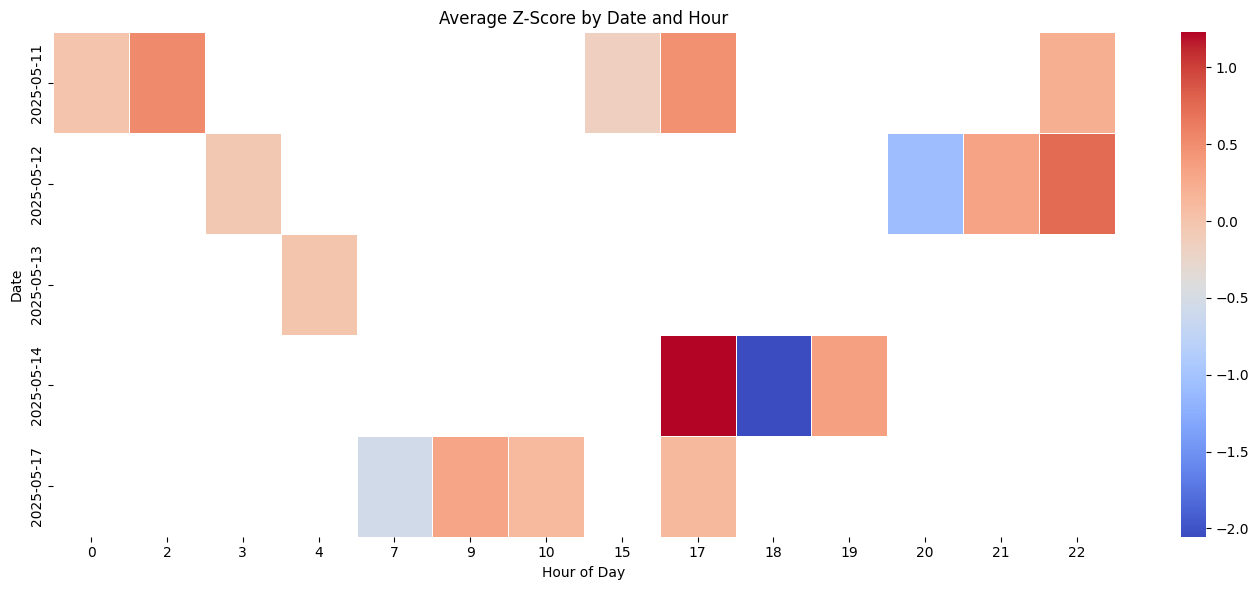

In [24]:
# Z-score Heatmap (calendar-style by hour)

ewma_df["hour"] = ewma_df["window_start"].dt.floor("H")
hourly_avg = ewma_df.groupby("hour")["z_score"].mean().reset_index()
pivot_df = hourly_avg.pivot_table(index=hourly_avg["hour"].dt.date, columns=hourly_avg["hour"].dt.hour, values="z_score")

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_df, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Average Z-Score by Date and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Date")
plt.tight_layout()
plt.show()

### Distribution of Anomalous vs Normal Time Windows

This pie chart shows how many of the 1-minute windows were considered anomalous versus normal, based on EWMA tracking.

This helps us understand whether the model is over-flagging or under-flagging anomalies. A small anomaly share suggests high precision and trust in the alerts.

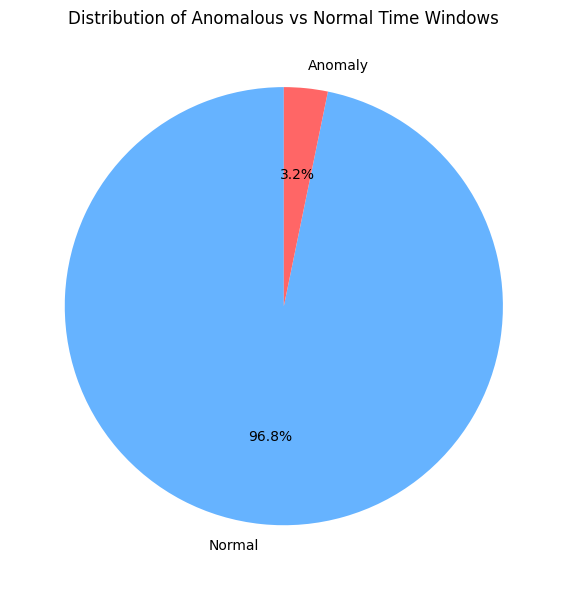

In [25]:
# Pie Chart of Anomalies vs Normal

counts = ewma_df["is_anomaly"].value_counts()
labels = ["Normal", "Anomaly"]
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=["#66b3ff", "#ff6666"])
plt.title("Distribution of Anomalous vs Normal Time Windows")
plt.tight_layout()
plt.show()

## Plot Coordinated Attack Candidates

This chart shows when and how many suspicious transactions were flagged for potential coordination.

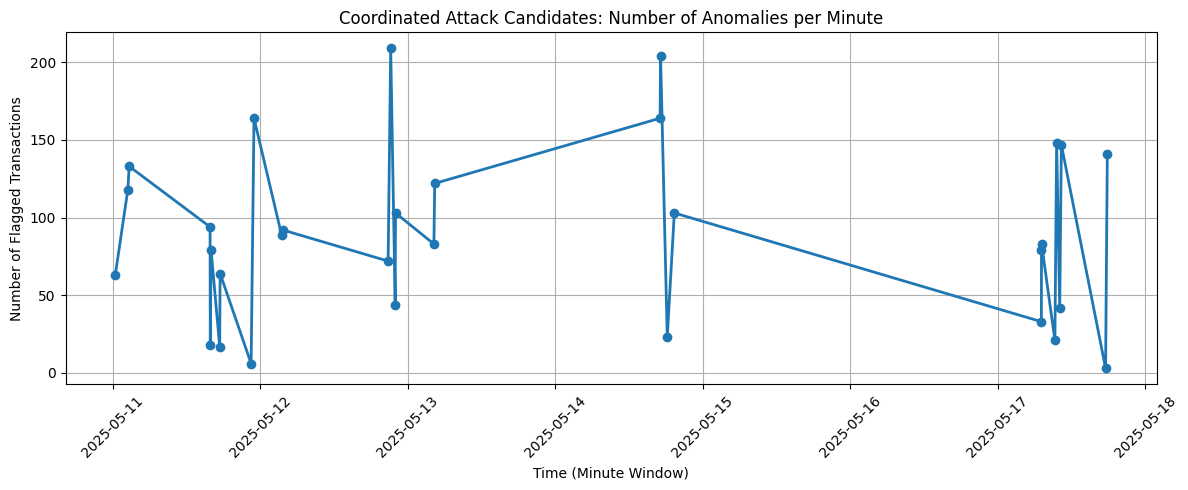

In [28]:
attacks_df = pd.read_csv("../report/coordinated_attacks.csv", parse_dates=["minute"])

plt.figure(figsize=(12, 5))
plt.plot(attacks_df["minute"], attacks_df["total_flagged"], marker='o', linewidth=2)
plt.title("Coordinated Attack Candidates: Number of Anomalies per Minute")
plt.xlabel("Time (Minute Window)")
plt.ylabel("Number of Flagged Transactions")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Anomalies by Hour of Day

This bar chart counts the number of anomalies detected during each hour of the day. It helps surface patterns in when suspicious behavior tends to occur.

In our case, we observe spikes during specific hour windows, which could indicate automated behavior or regional influence.

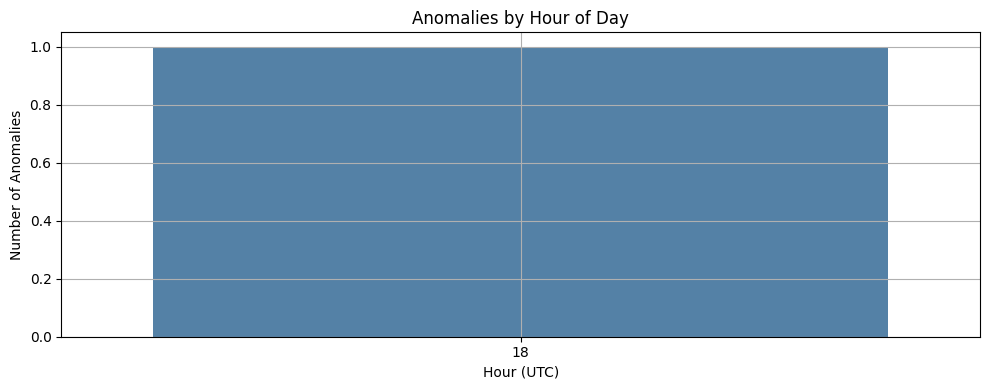

In [27]:
# Bar Chart of Anomalies by Hour

ewma_df["hour"] = ewma_df["window_start"].dt.hour
hourly_counts = ewma_df[ewma_df["is_anomaly"] == 1]["hour"].value_counts().sort_index()
plt.figure(figsize=(10, 4))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color="steelblue")
plt.title("Anomalies by Hour of Day")
plt.xlabel("Hour (UTC)")
plt.ylabel("Number of Anomalies")
plt.grid(True)
plt.tight_layout()
plt.show()

## Forecast Anomaly Trends

This script runs a Facebook Prophet model to forecast future transaction surges and anomaly clusters based on prior EWMA signals.

In [29]:
from BitcoinTxAnomaly_utils import run_forecast

run_forecast()

[RUN] Running forecast_with_prophet.py...
[INFO] Forecast saved to ../report/prophet_forecast.csv


19:18:46 - cmdstanpy - INFO - Chain [1] start processing
19:18:46 - cmdstanpy - INFO - Chain [1] done processing


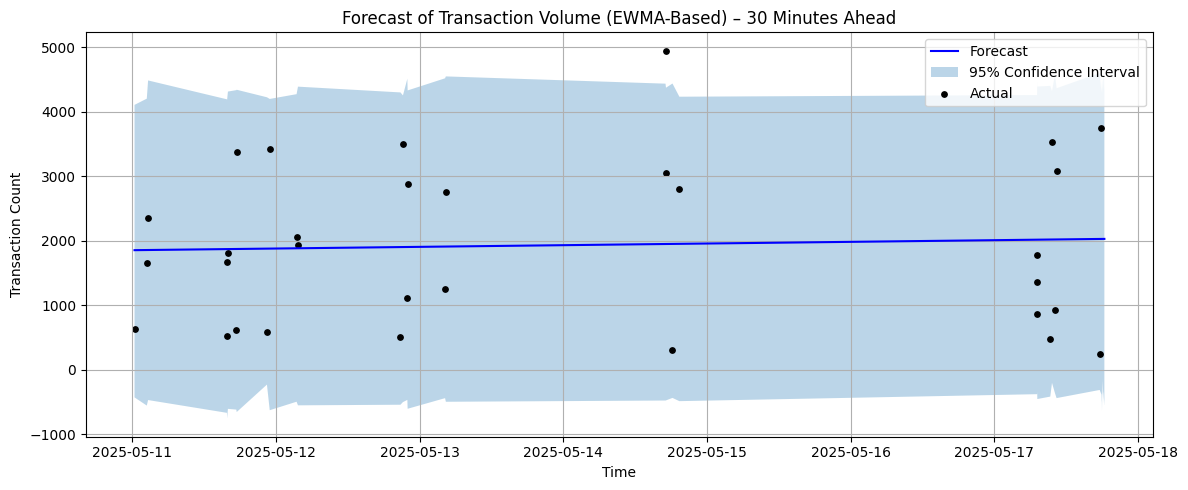

In [30]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load both forecast and actual data
forecast_df = pd.read_csv("../report/prophet_forecast.csv")
forecast_df["ds"] = pd.to_datetime(forecast_df["ds"])

original_df = pd.read_csv("../report/ewma_anomalies.csv")
original_df["window_start"] = pd.to_datetime(original_df["window_start"])
actual_points = original_df.rename(columns={"window_start": "ds", "tx_count_1min": "y"})

# Plot forecast + actuals
plt.figure(figsize=(12, 5))
plt.plot(forecast_df["ds"], forecast_df["yhat"], label="Forecast", color="blue")
plt.fill_between(forecast_df["ds"],
                 forecast_df["yhat_lower"],
                 forecast_df["yhat_upper"],
                 alpha=0.3, label="95% Confidence Interval")

# Actual values (black dots)
plt.scatter(actual_points["ds"], actual_points["y"], color="black", label="Actual", s=15)

plt.title("Forecast of Transaction Volume (EWMA-Based) – 30 Minutes Ahead")
plt.xlabel("Time")
plt.ylabel("Transaction Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Launch Dashboard

Use this to start the interactive dashboard served via Dash.

In [31]:
import os
import subprocess
import signal
import psutil

# Path to Dash app
dash_script_path = os.path.abspath("../dashboards/dashboard_app.py")

# Kill any existing Dash app processes
def kill_existing_dash():
    for proc in psutil.process_iter(['pid', 'name', 'cmdline']):
        try:
            if proc.info["cmdline"] and "dashboard_app.py" in " ".join(proc.info["cmdline"]):
                print(f"[INFO] Killing existing Dash process (PID {proc.pid})")
                proc.kill()
        except (psutil.NoSuchProcess, psutil.AccessDenied):
            continue

# Kill if already running
kill_existing_dash()

# Launch new Dash app
print("[INFO] Launching Dash dashboard...")
subprocess.Popen(["python3", dash_script_path])

[INFO] Killing existing Dash process (PID 1298)
[INFO] Launching Dash dashboard...


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app 'dashboard_app'
 * Debug mode: on
